In [1]:
import sys, os
sys.path.append('..')

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import pandas as pd

from source import pipeline, model, data_utils, features

In [2]:
config = {
    'build_dir': '_build/',
    'target': 'Winner',
    'features':  ['seed_num_team_1', 'seed_num_team_2', 'seed_diff',
                  'kenpom_adj_o_team1', #'kenpom_adj_o_team2',
                  'kenpom_adj_o_diff', 'kenpom_adj_o_rank_team1',
                  #'kenpom_adj_o_rank_team2',
                  'kenpom_adj_o_rank_diff',
                  'kenpom_adj_d_team1', #'kenpom_adj_d_team2',
                  'kenpom_adj_d_diff',
                  'kenpom_adj_d_rank_team1',
                  #'kenpom_adj_d_rank_team2',
                  'kenpom_adj_d_rank_diff', 
                  'kenpom_rank_team1', #'kenpom_rank_team2',
                  'kenpom_rank_diff', 'kenpom_luck_team1', #'kenpom_luck_team2',
                  'kenpom_luck_diff', 'kenpom_adjem_team1', #'kenpom_adjem_team2',
                  'kenpom_adjem_diff'],
    'model_params': {
        'categorical_features': None,
        'n_estimators': 250,  # Number of trees to fit.
        'early_stopping_rounds':10,
        'eval_metric': 'binary_logloss',
        'min_data_per_group': 3,
        'learning_rate': 0.01,
        'num_leaves': 10
    }
}

In [3]:
pipeline.build(config)

Creating evaluation set
Training lightgbm model on 642 x 17 data set
Early stopping in effect (rounds = 10)
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Number

/Users/jwrichar/miniconda/envs/py3/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Loading model from file


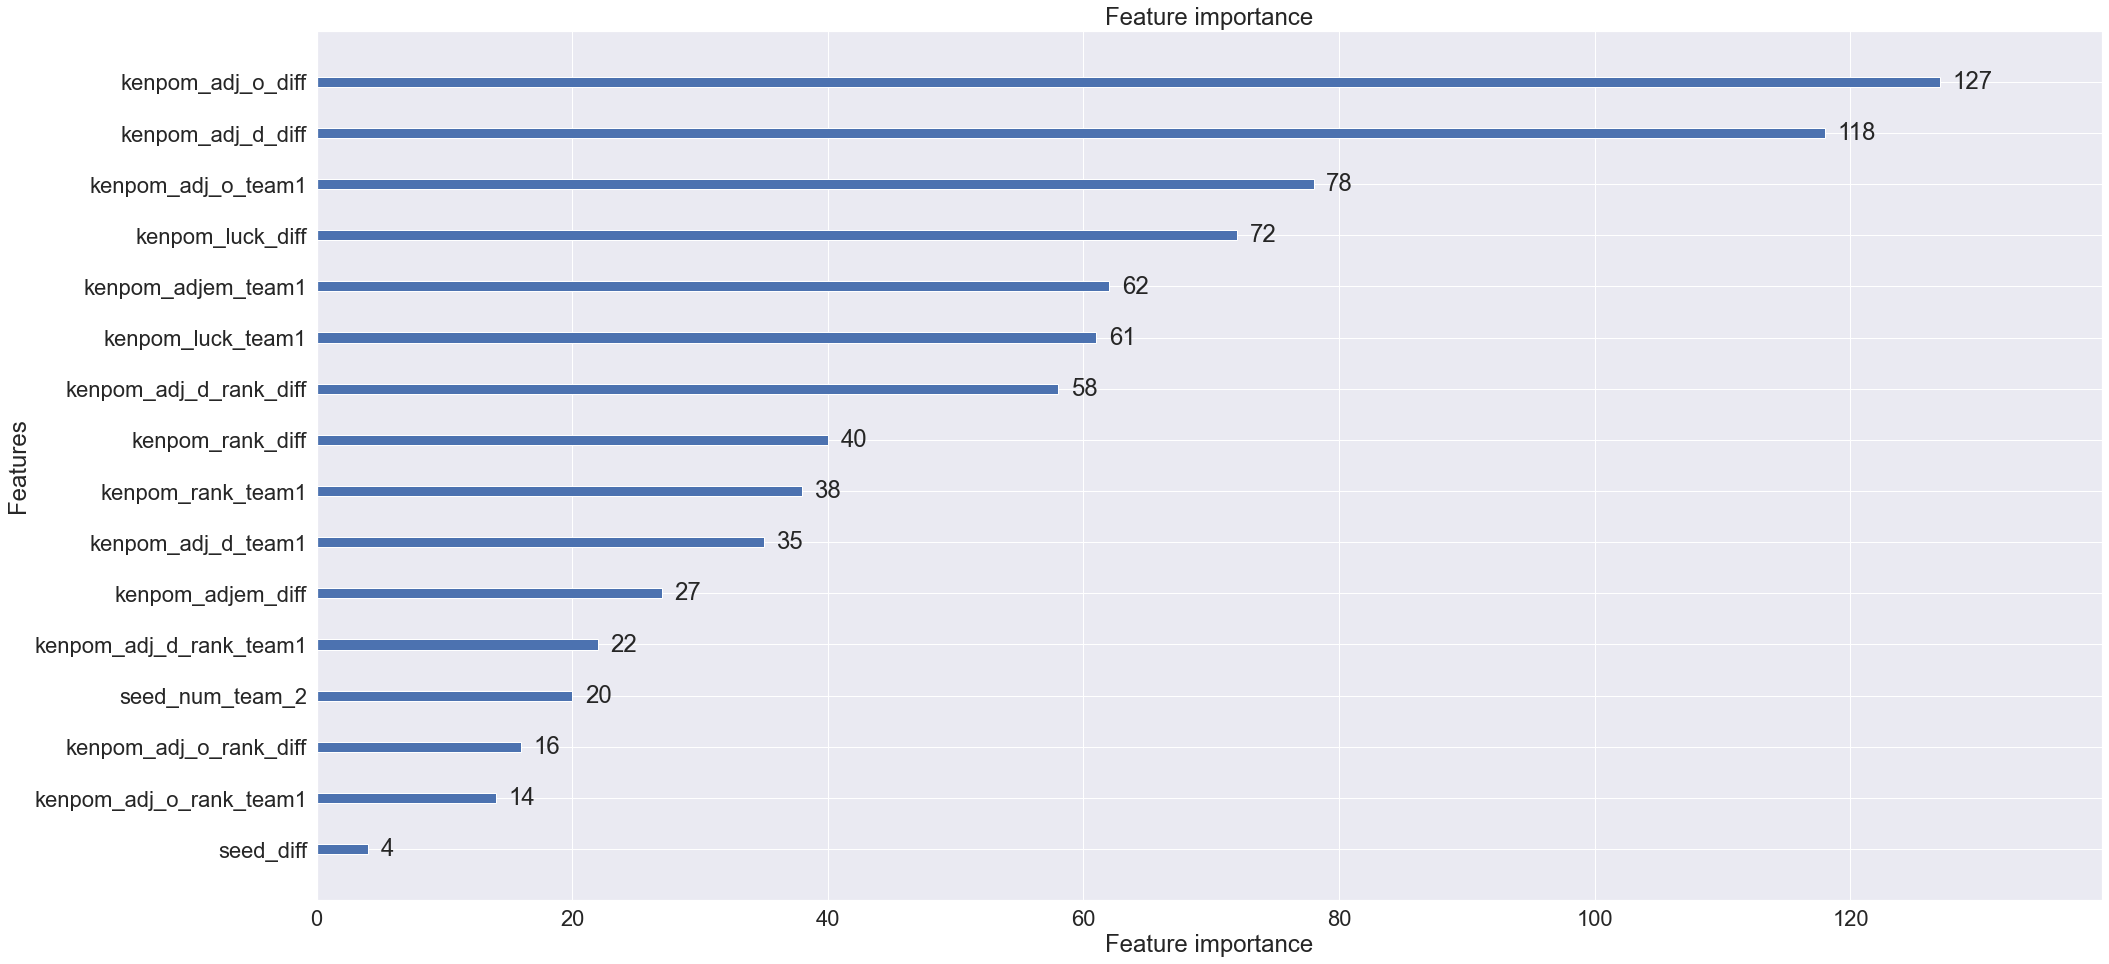

In [4]:
import lightgbm
os.environ['BUILD_DIR'] = '_build/'

m = model.BoostingModel()
m.load()

sns.set(rc={'figure.figsize':(32,16)})
sns.set(font_scale = 2)
lightgbm.plot_importance(m.model)

In [5]:
# Run a simple train-test
df = data_utils.compile_training_data(2011, 2023)

# Add kenpom features to master df
features.add_kenpom_features(df)

params = config['model_params']
params['target'] = 'Winner'

# Holdout on season
frac=0.1
y_true, y_pred = model.train_test(df, params, holdout_sort='column', column='Season', frac=frac)

Performing holdout split of 0.10 fraction of data of type "column".
Creating evaluation set
Training lightgbm model on 577 x 28 data set
Early stopping in effect (rounds = 10)
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be

/Users/jwrichar/miniconda/envs/py3/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [6]:
split_params = {
    'sort': 'column',
    'fraction': frac,
    'column': 'Season'
}
df_train, df_test = model.split_data(df, split_params)

# Proportion correct
print('Model proportion correct:')
print((y_true == y_pred['values']).sum() / float(len(y_true)))

# Chalk prediction
y_pred_chalk = df_test['seed_diff'].apply(lambda x: 'Team1' if x <= 0 else 'Team2')
print('Chalk proportion correct:')
print((y_true == y_pred_chalk).sum() / float(len(y_true)))


Performing holdout split of 0.10 fraction of data of type "column".
Model proportion correct:
0.7037037037037037
Chalk proportion correct:
0.7160493827160493


In [7]:
print(pd.crosstab(y_true, y_pred['values']))

print(pd.crosstab(y_true, y_pred_chalk))


col_0   Team1  Team2
Winner              
Team1      56      2
Team2      22      1
seed_diff  Team1
Winner          
Team1         58
Team2         23


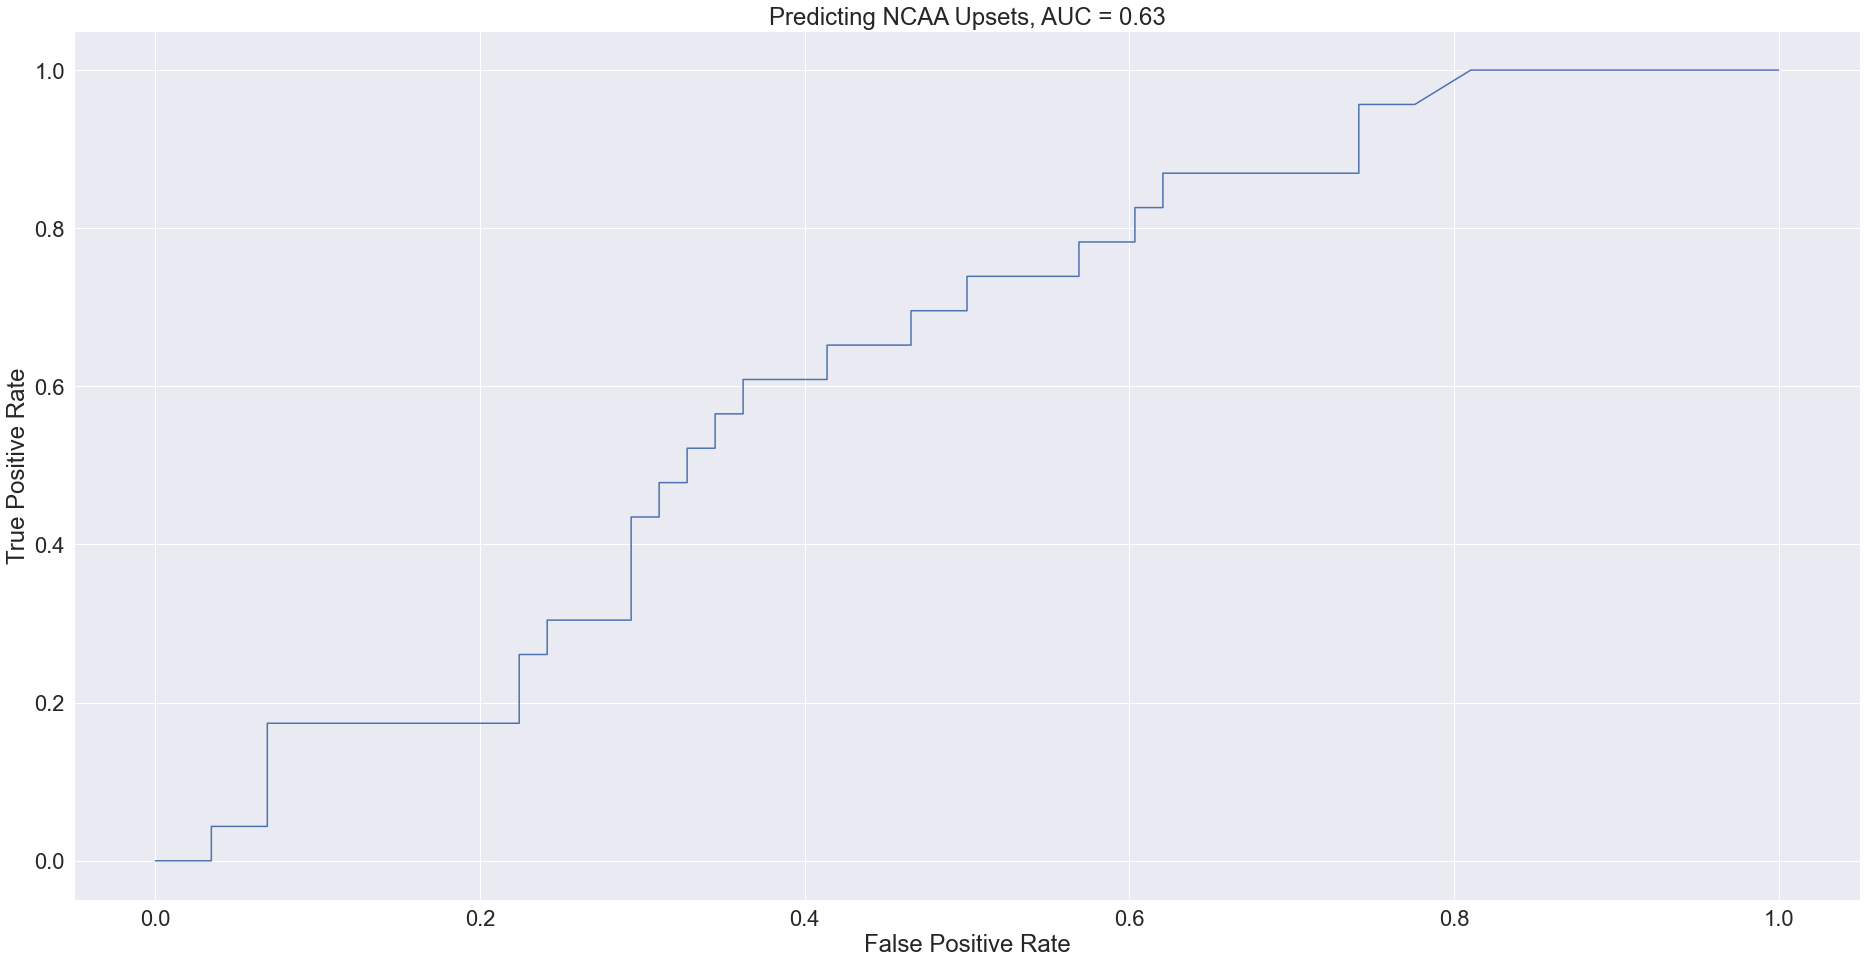

In [8]:
from sklearn import metrics
y_true_bool = y_true.apply(lambda x: 1 if x=='Team2' else 0)
fpr, tpr, thresholds = metrics.roc_curve(y_true_bool,  y_pred['scores']['Team2'])
auc = metrics.roc_auc_score(y_true_bool, y_pred['scores']['Team2'])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Predicting NCAA Upsets, AUC = %.2f' % auc)
plt.plot([0, 0], [1, 1], 'r-', lw=3)

In [9]:
thresh_team2 = thresholds[abs(tpr - 0.4).argmin()]
print("Threshold:")
print(thresh_team2)
y_pred_thresh = y_pred['scores']['Team2'].apply(lambda x: 'Team2' if x>thresh_team2 else 'Team1')
y_pred_thresh.index = y_true.index

print(pd.crosstab(y_true, y_pred_thresh))

print(pd.crosstab(y_true, y_pred_chalk))


Threshold:
0.3590430972262786
Team2   Team1  Team2
Winner              
Team1      41     17
Team2      14      9
seed_diff  Team1
Winner          
Team1         58
Team2         23


In [10]:
df_test

,Season,TeamID1,seed_num_team_1,TeamID2,seed_num_team_2,Winner,Margin,seed_diff,kenpom_adj_o_team1,kenpom_adj_o_team2,...,kenpom_adj_d_rank_diff,kenpom_rank_team1,kenpom_rank_team2,kenpom_rank_diff,kenpom_luck_team1,kenpom_luck_team2,kenpom_luck_diff,kenpom_adjem_team1,kenpom_adjem_team2,kenpom_adjem_diff
2347,2022,1345,3,1463,14,Team1,22,-11,121.3,101.5,...,-3,14,147,-133,0.035,0.061,-0.026,22.29,2.23,20.06
2346,2022,1326,7,1260,10,Team1,13,-3,116.6,110.9,...,109,32,24,8,-0.015,0.016,-0.031,15.82,17.69,-1.87
2345,2022,1104,6,1323,11,Team2,14,-5,116.1,112.0,...,10,25,52,-27,-0.022,0.016,-0.038,17.36,13.63,3.73
2344,2022,1277,7,1172,10,Team1,1,-3,111.3,116.8,...,-99,40,41,-1,0.050,-0.004,0.054,14.87,14.80,0.07
2343,2022,1425,7,1274,10,Team2,2,-3,110.5,114.8,...,-108,42,62,-20,0.077,0.069,0.008,14.45,12.62,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2023,1417,2,1421,15,Team1,33,-13,114.9,104.1,...,-114,2,146,-144,-0.001,0.152,-0.153,27.63,1.51,26.12
2402,2023,1400,2,1159,15,Team1,20,-13,116.6,113.0,...,-220,6,114,-108,0.020,0.004,0.016,24.57,5.29,19.28
2401,2023,1397,4,1418,13,Team1,3,-9,112.7,112.2,...,-144,5,92,-87,-0.071,0.077,-0.148,24.71,8.20,16.51
2407,2023,1345,1,1192,16,Team2,5,-15,119.4,106.2,...,-335,7,312,-305,0.032,0.017,0.015,24.55,-12.25,36.80
